In [3]:
from pathlib import Path
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
base_path = Path("D:\\SILVEX II 2025\\EC data\\Silvia 2 (oben)\\EddyPro")
#Path("/Volumes/SILVEX2S2/SILVEX II 2025/EC data/Silvia 2 (oben)/EddyPro")
files = {
    "1m": {
        "full": base_path / "1m" / "eddypro_25Silvia21_full_output_2026-01-08T164620_adv.csv",
        "st7": base_path / "1m" / "eddypro_stats" / "eddypro_25Silvia21_st7_2026-01-08T164620_adv.csv",
    },
    "2m": {
        "full": base_path / "2m" / "eddypro_25Silvia22_full_output_2026-01-13T151233_adv.csv",
        "st7": base_path / "2m" / "eddypro_stats" / "eddypro_25Silvia22_st7_2026-01-13T151233_adv.csv",
    },
    "3m": {
        "full": base_path / "3m" / "eddypro_25Silvia23_full_output_2026-01-14T121836_adv.csv",
        "st7": base_path / "3m" / "eddypro_stats" / "eddypro_25Silvia23_st7_2026-01-14T121836_adv.csv",
    },
}

missing = [path for sensor in files.values() for path in sensor.values() if not path.exists()]
if missing:
    raise FileNotFoundError(f"Missing expected file(s): {missing}")


def read_header_rows(path: Path, rows: int) -> list[list[str]]:
    collected: list[list[str]] = []
    with path.open(newline="", encoding="utf-8", errors="replace") as handle:
        reader = csv.reader(handle)
        for _ in range(rows):
            try:
                collected.append(next(reader))
            except StopIteration:
                break
    return collected


full_outputs: dict[str, pd.DataFrame] = {}
st7_outputs: dict[str, pd.DataFrame] = {}

for sensor, paths in files.items():
    print(f"Processing sensor {sensor}")

    full_header_rows = read_header_rows(paths["full"], 3)
    if len(full_header_rows) < 3:
        raise ValueError(f"Expected three header rows in {paths['full'].name}, found fewer.")

    max_cols = max(len(row) for row in full_header_rows)
    header_arrays: list[list[str]] = []
    for row in full_header_rows:
        padded = row + [""] * (max_cols - len(row))
        header_arrays.append(padded)
    column_labels = list(zip(*header_arrays))

    full_df = pd.read_csv(paths["full"], skiprows=3, header=None)
    actual_cols = full_df.shape[1]
    full_df = full_df.iloc[:, :actual_cols]
    full_columns = pd.MultiIndex.from_tuples(column_labels[:actual_cols], names=["category", "variable", "unit"])
    full_df.columns = full_columns
    full_outputs[sensor] = full_df
    print(f"  Full output shape: {full_df.shape}")

    st7_df = pd.read_csv(paths["st7"], skiprows=1)
    st7_outputs[sensor] = st7_df
    print(f"  ST7 shape: {st7_df.shape}")

    if sensor == "1m":
        with pd.option_context("display.max_columns", None, "display.width", None):
            print("  1m full output preview (first 5 rows):")
            display(full_df.head(5))
            print("  1m ST7 preview (first 5 rows):")
            display(st7_df.head(5))

# Convenience bindings for the 1 m sensor (used in later cells for plotting)
full_output_df = full_outputs["1m"]
st7_df = st7_outputs["1m"]


Processing sensor 1m
  Full output shape: (43190, 81)
  ST7 shape: (43190, 88)
  1m full output preview (first 5 rows):


category                                file_info                       \
variable                                 filename         date    time   
unit                                              [yyyy-mm-dd] [HH:MM]   
0         2025-06-23_1140_SILVEXII_Silvia2_1m.dat   2025-06-23   11:41   
1         2025-06-23_1140_SILVEXII_Silvia2_1m.dat   2025-06-23   11:42   
2         2025-06-23_1140_SILVEXII_Silvia2_1m.dat   2025-06-23   11:43   
3         2025-06-23_1140_SILVEXII_Silvia2_1m.dat   2025-06-23   11:44   
4         2025-06-23_1140_SILVEXII_Silvia2_1m.dat   2025-06-23   11:45   

category                                                  \
variable       DOY     daytime file_records used_records   
unit     [ddd.ddd] [1=daytime]          [#]          [#]   
0         174.4867         1.0       1200.0       1038.0   
1         174.4874         1.0       1200.0       1036.0   
2         174.4881         1.0       1200.0       1035.0   
3         174.4888         1.0       1200.0       1038.0   
4         174.4895         1.0       1200.0       1032.0   

category corrected_fluxes_and_quality_flags                        \
variable                                Tau qc_Tau         H qc_H   
unit                           [kg+1m-1s-2]    [#]  [W+1m-2]  [#]   
0                                 -0.053525    2.0 -147.0800  2.0   
1                                  0.018656    2.0  -64.3289  2.0   
2                                  0.077339    2.0 -131.5750  2.0   
3                                  0.026542    2.0  -70.1846  2.0   
4                                 -0.032137    2.0  -52.0279  2.0   

category storage_fluxes  \
variable         H_strg   
unit           [W+1m-2]   
0                   NaN   
1              -26.5793   
2               31.7788   
3              -13.8014   
4                6.5940   

category vertical_advection_fluxesgas_densities_concentrations_and_timelagsair_properties  \
variable                                                                sonic_temperature   
unit                                                                                  [K]   
0                                                   284.687                                 
1                                                   283.083                                 
2                                                   285.014                                 
3                                                   284.178                                 
4                                                   284.578                                 

category                                                             \
variable air_temperature air_pressure air_density air_heat_capacity   
unit                 [K]         [Pa]   [kg+1m-3]      [J+1kg-1K-1]   
0                284.687      73058.3    0.894044           1005.36   
1                283.083      73058.3    0.899110           1005.32   
2                285.014      73058.3    0.893019           1005.36   
3                284.178      73058.3    0.895647           1005.35   
4                284.578      73058.3    0.894388           1005.35   

category                                                                  \
variable air_molar_volume           ET water_vapor_density    e       es   
unit           [m+3mol-1] [mm+1hour-1]           [kg+1m-3] [Pa]     [Pa]   
0                0.032397          NaN                 NaN  NaN  1356.21   
1                0.032215          NaN                 NaN  NaN  1218.82   
2                0.032434          NaN                 NaN  NaN  1385.81   
3                0.032339          NaN                 NaN  NaN  1311.18   
4                0.032385          NaN                 NaN  NaN  1346.43   

category                                 unrotated_wind                      \
variable specific_humidity  RH  VPD Tdew        u_unrot   v_unrot   w_unrot   
unit            [kg+1kg-1] [%] [Pa]  [K]       [m+1s-1]  [m+1s-1]  [m+1s-1]

  1m ST7 preview (first 5 rows):


,filename,date,time,DOY,used_records,mean(u),mean(v),mean(w),mean(ts),mean(co2),mean(h2o),mean(ch4),mean(none),mean(tc),mean(pc),mean(te),mean(pe),WindDirection,var(u),var(v),var(w),var(ts),var(co2),var(h2o),var(ch4),var(none),var(tc),var(pc),var(te),var(pe),cov(u/v),cov(u/w),cov(u/ts),cov(u/co2),cov(u/h2o),cov(u/ch4),cov(u/none),cov(v/w),cov(v/ts),cov(v/co2),cov(v/h2o),cov(v/ch4),cov(v/none),cov(w/ts),cov(w/co2),cov(w/h2o),cov(w/ch4),cov(w/none),cov(w/tc),cov(w/pc),cov(w/te),cov(w/pe),st_dev(u),st_dev(v),st_dev(w),st_dev(ts),st_dev(co2),st_dev(h2o),st_dev(ch4),st_dev(none),st_dev(tc),st_dev(pc),st_dev(te),st_dev(pe),skw(u),skw(v),skw(w),skw(ts),skw(co2),skw(h2o),skw(ch4),skw(none),skw(tc),skw(pc),skw(te),skw(pe),kur(u),kur(v),kur(w),kur(ts),kur(co2),kur(h2o),kur(ch4),kur(none),kur(tc),kur(pc),kur(te),kur(pe)
0,2025-06-23_1140_SILVEXII_Silvia2_1m.dat,2025-06-23,11:41,174.4867,1200.0,1.226260,-5.310430e-15,-1.592770e-15,284.687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.344,0.254300,0.280988,0.093613,1.267560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.041814,-0.007079,0.135206,NaN,NaN,NaN,NaN,0.055542,-0.225514,NaN,NaN,NaN,NaN,-0.153038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.504282,0.530083,0.305962,1.125860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.239978,-0.828607,-1.247890,-0.309776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.50136,3.45242,5.44572,2.26299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-06-23_1140_SILVEXII_Silvia2_1m.dat,2025-06-23,11:42,174.4874,1200.0,1.792440,2.103410e-15,1.150520e-15,283.083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.244,0.132651,0.344104,0.025077,1.327250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060061,0.008759,-0.112540,NaN,NaN,NaN,NaN,0.017194,-0.267832,NaN,NaN,NaN,NaN,-0.066186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.364213,0.586604,0.158359,1.152060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.474978,-1.025850,-0.399911,0.549084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.06111,3.61570,4.26792,3.33147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-06-23_1140_SILVEXII_Silvia2_1m.dat,2025-06-23,11:43,174.4881,1200.0,1.143110,5.141570e-15,-8.614660e-16,285.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.449,0.293184,0.412494,0.068837,1.118180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.198129,0.076957,-0.269380,NaN,NaN,NaN,NaN,0.024269,0.026424,NaN,NaN,NaN,NaN,-0.136549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.541465,0.642257,0.262369,1.057440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.579789,-0.828106,-0.468830,-0.287251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.44747,2.75701,2.77495,2.39235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-06-23_1140_SILVEXII_Silvia2_1m.dat,2025-06-23,11:44,174.4888,1200.0,0.829677,8.304920e-15,-6.414380e-19,284.178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.403,1.158900,0.418614,0.080589,0.976138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.590338,0.025979,-0.437479,NaN,NaN,NaN,NaN,-0.008445,-0.187331,NaN,NaN,NaN,NaN,-0.071852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.076520,0.647004,0.283882,0.987997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.377260,-1.213770,0.150824,-0.236324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.64182,3.63277,4.25624,2.02535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-06-23_1140_SILVEXII_Silvia2_1m.dat,2025-06-23,11:45,174.4895,1200.0,0.711670,2.601280e-15,1.538020e-15,284.578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.428,0.189781,0.197547,0.048712,0.260517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.042374,-0.027127,0.066649,NaN,NaN,NaN,NaN,0.018488,-0.105536,NaN,NaN,NaN,NaN,-0.052863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.435639,0.444463,0.220708,0.510409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068622,-0.067219,-0.128808,-0.557990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.52222,2.24724,2.63740,3.06245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Processing sensor 2m
  Full output shape: (43190, 77)
  ST7 shape: (43190, 88)
Processing sensor 3m
  Full output shape: (43190, 77)
  ST7 shape: (43190, 88)


In [5]:
def flatten_label(label) -> str:
    if isinstance(label, tuple):
        parts = [str(part).strip() for part in label if str(part).strip()]
        return " | ".join(parts)
    return str(label).strip()

def find_column(df, keyword_groups):
    for keywords in keyword_groups:
        for col in df.columns:
            label = flatten_label(col).lower()
            if all(keyword in label for keyword in keywords):
                return col, flatten_label(col)
    return None, None

def get_timestamp_series(df):
    timestamp_keywords = [
        ["timestamp"],
        ["date", "time"],
        ["datetime"],
    ]
    col, label = find_column(df, timestamp_keywords[:1])
    if col is not None:
        series = pd.to_datetime(df[col], errors="coerce")
        if series.notna().any():
            return series, label
    date_col, date_label = find_column(df, [["date"]])
    time_col, time_label = find_column(df, [["time"]])
    if date_col is not None and time_col is not None:
        combo = (df[date_col].astype(str).str.strip() + " " + df[time_col].astype(str).str.strip())
        series = pd.to_datetime(combo, errors="coerce")
        if series.notna().any():
            return series, f"{flatten_label(date_col)} + {flatten_label(time_col)}"
    raise ValueError("Could not locate a usable timestamp column in the dataframe.")

def wind_direction_mean(series: pd.Series) -> float:
    valid = series.dropna().astype(float)
    if valid.empty:
        return np.nan
    radians = np.deg2rad(valid)
    sin_mean = np.sin(radians).mean()
    cos_mean = np.cos(radians).mean()
    return (np.degrees(np.arctan2(sin_mean, cos_mean)) + 360) % 360

wind_speed_keywords = [["mean(u)"], ["mean", "wind", "speed"], ["u_mean"], ["wind_speed"]]
wind_dir_keywords = [["wind direction"], ["wind_dir"], ["wind", "dir"]]

sensor_series_info: dict[str, dict[str, str]] = {}
wind_series_raw: dict[str, pd.DataFrame] = {}
wind_series_30min: dict[str, pd.DataFrame] = {}

for sensor, df in full_outputs.items():
    try:
        timestamp, timestamp_label = get_timestamp_series(df)
    except ValueError as exc:
        print(f"Skipping sensor {sensor}: {exc}")
        continue

    ws_col, ws_label = find_column(df, wind_speed_keywords)
    wd_col, wd_label = find_column(df, wind_dir_keywords)
    if ws_col is None or wd_col is None:
        print(f"Skipping sensor {sensor}: could not locate wind speed/direction columns")
        continue

    wind_speed_series = pd.to_numeric(df.loc[:, ws_col], errors="coerce")
    wind_dir_series = pd.to_numeric(df.loc[:, wd_col], errors="coerce")

    sensor_df = pd.DataFrame({
        "timestamp": timestamp,
        "wind_speed": wind_speed_series,
        "wind_direction": wind_dir_series,
    }).dropna(subset=["timestamp"])
    sensor_df = sensor_df.sort_values("timestamp")
    wind_series_raw[sensor] = sensor_df

    if sensor_df.empty:
        print(f"Sensor {sensor} has no valid timestamped samples; skipping resample")
        continue

    indexed = sensor_df.set_index("timestamp")
    resampled = indexed.resample("30min").agg({
        "wind_speed": "mean",
        "wind_direction": wind_direction_mean,
    })
    resampled["sample_count"] = indexed["wind_speed"].resample("30min").count()
    wind_series_30min[sensor] = resampled

    sensor_series_info[sensor] = {
        "timestamp_label": timestamp_label,
        "ws_label": flatten_label(ws_col),
        "wd_label": flatten_label(wd_col),
    }

    print(
        f"Sensor {sensor}: {len(sensor_df)} samples -> {resampled.shape[0]} 30-min bins; "
        f"wind speed column='{flatten_label(ws_col)}', wind direction column='{flatten_label(wd_col)}'"
    )

Sensor 1m: 43190 samples -> 1441 30-min bins; wind speed column='wind_speed | [m+1s-1]', wind direction column='wind_dir | [deg_from_north]'
Sensor 2m: 43190 samples -> 1441 30-min bins; wind speed column='wind_speed | [m+1s-1]', wind direction column='wind_dir | [deg_from_north]'
Sensor 3m: 43190 samples -> 1441 30-min bins; wind speed column='wind_speed | [m+1s-1]', wind direction column='wind_dir | [deg_from_north]'


Sensor 1m: timestamp=date | [yyyy-mm-dd] + time | [HH:MM], wind speed=wind_speed | [m+1s-1], wind direction=wind_dir | [deg_from_north]
Sensor 2m: timestamp=date | [yyyy-mm-dd] + time | [HH:MM], wind speed=wind_speed | [m+1s-1], wind direction=wind_dir | [deg_from_north]
Sensor 3m: timestamp=date | [yyyy-mm-dd] + time | [HH:MM], wind speed=wind_speed | [m+1s-1], wind direction=wind_dir | [deg_from_north]


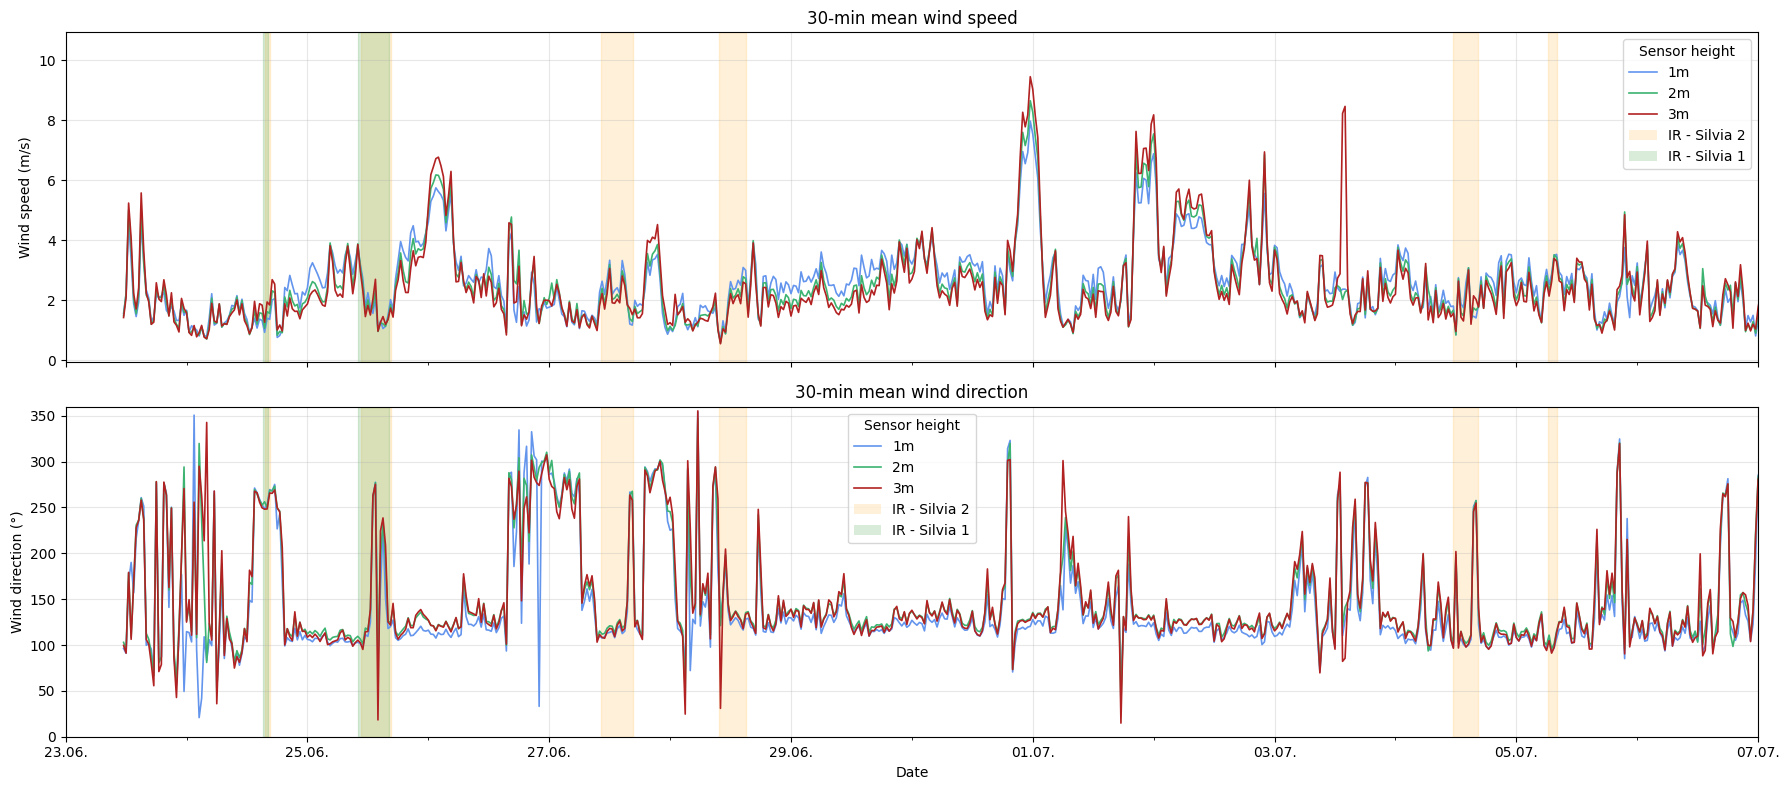

In [18]:
COLORS = {
    "1m": "cornflowerblue",
    "2m": "mediumseagreen",
    "3m": "firebrick",
}

ordered_sensors = [sensor for sensor in ["1m", "2m", "3m"] if sensor in wind_series_30min]
if not ordered_sensors:
    raise ValueError("No resampled wind series available; run the preprocessing cell first.")

for sensor in ordered_sensors:
    info = sensor_series_info.get(sensor, {})
    print(
        f"Sensor {sensor}: timestamp={info.get('timestamp_label', 'n/a')}, "
        f"wind speed={info.get('ws_label', 'n/a')}, wind direction={info.get('wd_label', 'n/a')}"
    )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

for sensor in ordered_sensors:
    resampled = wind_series_30min[sensor]
    color = COLORS.get(sensor, "gray")

    ax1.plot(resampled.index, resampled["wind_speed"], label=f"{sensor}", color=color, linewidth=1.2)
    ax2.plot(resampled.index, resampled["wind_direction"], label=f"{sensor}", color=color, linewidth=1.2)

ax1.set_ylabel("Wind speed (m/s)")
ax1.set_title("30-min mean wind speed")
ax1.grid(True, alpha=0.3)
ax1.legend(title="Sensor height")

ax2.set_ylabel("Wind direction (°)")
ax2.set_xlabel("Date")
ax2.set_title("30-min mean wind direction")
ax2.set_ylim(0, 360)
ax2.set_xlim(pd.Timestamp("2025-06-23"), pd.Timestamp("2025-07-07"))
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
ax2.tick_params(axis="x", which="major", rotation=0)
fig.autofmt_xdate(rotation=0, ha="center")
ax2.grid(True, alpha=0.3)
ax2.legend(title="Sensor height", loc="upper right")

# Add measurement window shading
add_measurement_windows(ax1)
add_measurement_windows(ax2)

plt.tight_layout()


In [14]:
def build_stats_series(column_keyword: str, transform=None):
    """Collect a per-sensor series for a column stored in the EddyPro ST7 stats outputs."""
    keyword_groups = [[column_keyword.lower()]]
    series: dict[str, pd.DataFrame] = {}
    for sensor, df in st7_outputs.items():
        try:
            timestamp, _ = get_timestamp_series(df)
        except ValueError:
            print(f"Sensor {sensor}: missing timestamp column; skipping {column_keyword}.")
            continue
        col, label = find_column(df, keyword_groups)
        if col is None:
            print(f"Sensor {sensor}: {column_keyword} column not found; skipping.")
            continue
        values = pd.to_numeric(df[col], errors="coerce")
        sensor_df = (
            pd.DataFrame({"timestamp": timestamp, "value": values})
            .dropna(subset=["timestamp"])
            .sort_values("timestamp")
        )
        if transform is not None:
            sensor_df["value"] = transform(sensor_df["value"])
        sensor_df = sensor_df.dropna(subset=["value"])
        if sensor_df.empty:
            print(f"Sensor {sensor}: no valid {column_keyword} values after cleaning; skipping.")
            continue
        series[sensor] = sensor_df
    return series

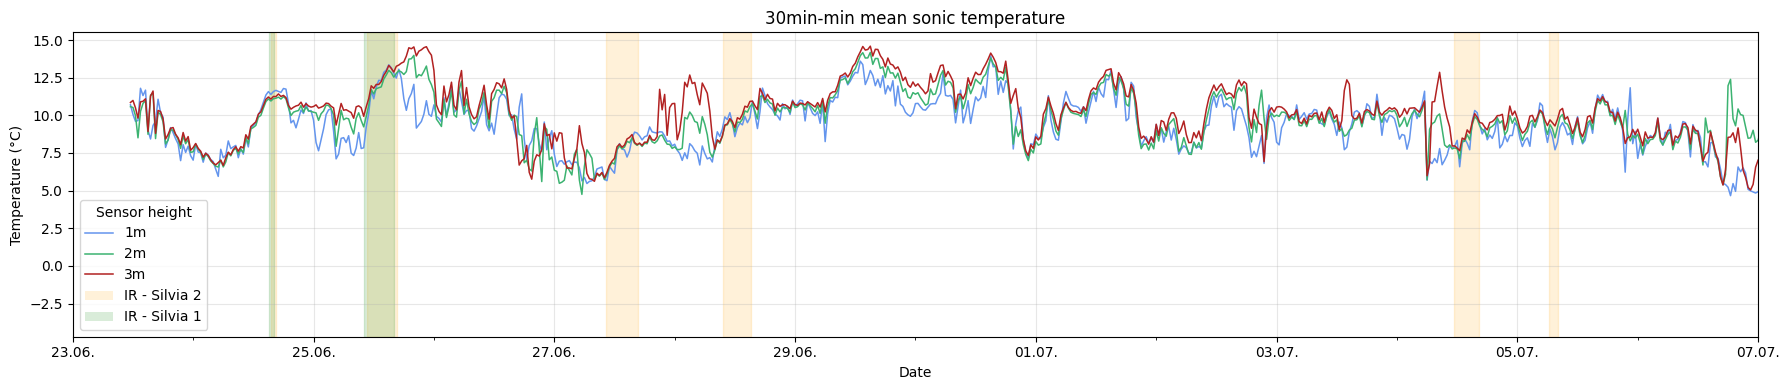

In [19]:
def block_average_series(
    series_dict: dict[str, pd.DataFrame],
    freq: str = "30min",
    preserve_gaps: bool = True,
) -> dict[str, pd.DataFrame]:
    """Resample sensor time series to block means while optionally keeping gap NaNs."""
    averaged: dict[str, pd.DataFrame] = {}
    for sensor, sensor_df in series_dict.items():
        if sensor_df is None or sensor_df.empty:
            averaged[sensor] = sensor_df
            continue
        averaged_df = sensor_df.set_index("timestamp").resample(freq).mean(numeric_only=True)
        if not preserve_gaps:
            averaged_df = averaged_df.dropna(subset=["value"])
        averaged[sensor] = averaged_df.reset_index()
    return averaged


def block_average_temperature(
    series_dict: dict[str, pd.DataFrame],
    freq: str = "30min",
    preserve_gaps: bool = True,
) -> dict[str, pd.DataFrame]:
    return block_average_series(series_dict, freq=freq, preserve_gaps=preserve_gaps)


def block_average_flux(
    series_dict: dict[str, pd.DataFrame],
    freq: str = "30min",
    preserve_gaps: bool = True,
) -> dict[str, pd.DataFrame]:
    return block_average_series(series_dict, freq=freq, preserve_gaps=preserve_gaps)


temperature_series = build_stats_series("mean(ts)", transform=lambda s: s - 273.15)
block_avg_freq = "30min"
averaged_temperature = block_average_temperature(
    temperature_series, freq=block_avg_freq, preserve_gaps=True
)


fig, ax = plt.subplots(figsize=(18, 4))
for sensor in ordered_sensors:
    sensor_data = averaged_temperature.get(sensor)
    if sensor_data is None or sensor_data.empty:
        continue
    color = COLORS.get(sensor, "gray")
    ax.plot(
        sensor_data["timestamp"],
        sensor_data["value"],
        label=sensor,
        color=color,
        linewidth=1.1,
    )

ax.set_title(f"{block_avg_freq}-min mean sonic temperature")
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Date")
ax.set_xlim(pd.Timestamp("2025-06-23"), pd.Timestamp("2025-07-07"))
ax.grid(True, alpha=0.3)
ax.legend(title="Sensor height")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
ax.tick_params(axis="x", which="major", rotation=0)
fig.autofmt_xdate(rotation=0, ha="center")

# Add measurement window shading
add_measurement_windows(ax)

plt.tight_layout()

<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
C:\Users\asemannp\AppData\Local\Temp\ipykernel_3552\2379137175.py:25: SyntaxWarning: invalid escape sequence '\o'
  (ax_along, "$\overline{u'T'}$ (m s⁻¹ K)", "Along-slope sensible heat flux $\overline{u'T'}$", -0.5, 1),
C:\Users\asemannp\AppData\Local\Temp\ipykernel_3552\2379137175.py:25: SyntaxWarning: invalid escape sequence '\o'
  (ax_along, "$\overline{u'T'}$ (m s⁻¹ K)", "Along-slo

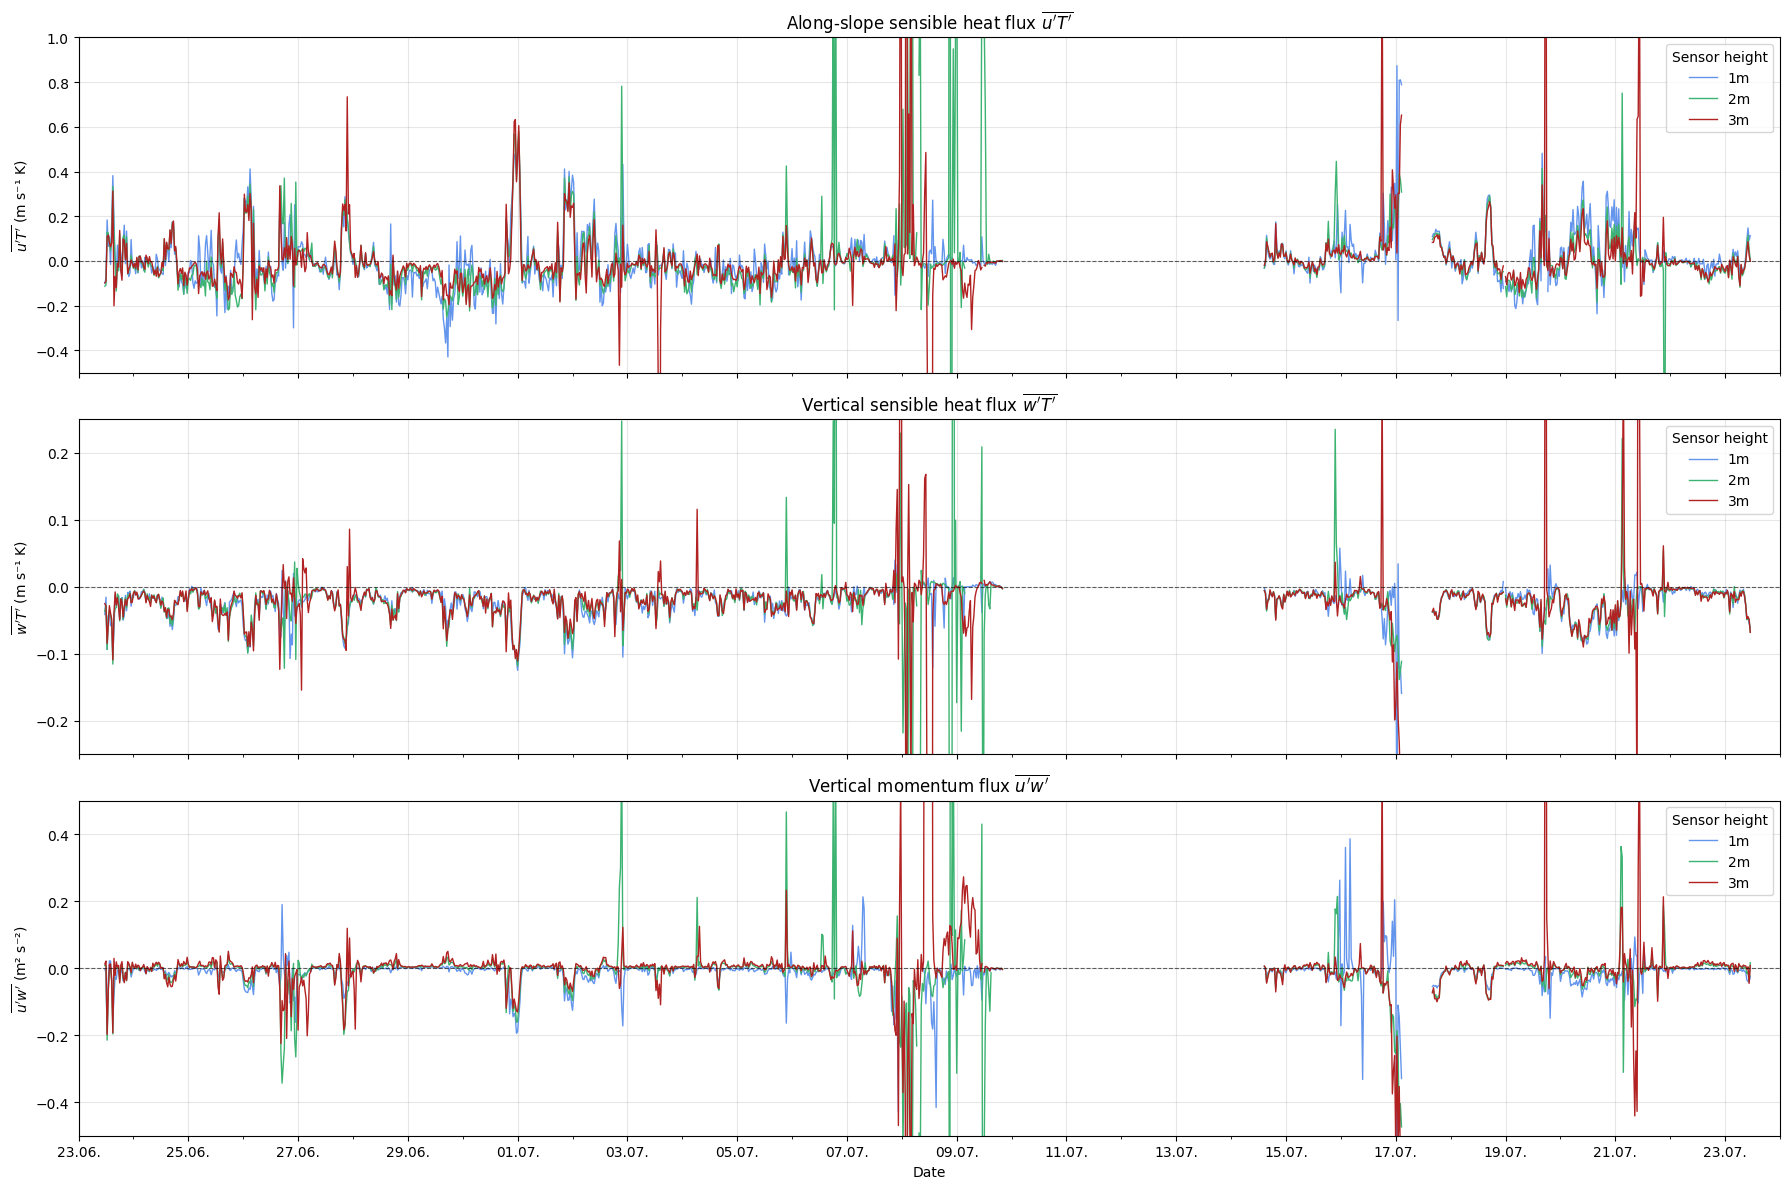

In [ ]:
along_slope_flux = build_stats_series("cov(u/ts)")
vertical_heat_flux = build_stats_series("cov(w/ts)")
vertical_momentum_flux = build_stats_series("cov(u/w)")
block_avg_freq = "30min"
avg_along_flux = block_average_flux(along_slope_flux, freq=block_avg_freq, preserve_gaps=True)
avg_vertical_heat_flux = block_average_flux(vertical_heat_flux, freq=block_avg_freq, preserve_gaps=True)
avg_vertical_mom_flux = block_average_flux(vertical_momentum_flux, freq=block_avg_freq, preserve_gaps=True)

fig, axes = plt.subplots(3, 1, figsize=(18, 12), sharex=True)
ax_along, ax_vert_heat, ax_vert_mom = axes
for sensor in ordered_sensors:
    color = COLORS.get(sensor, "gray")
    along_data = avg_along_flux.get(sensor)
    vert_heat_data = avg_vertical_heat_flux.get(sensor)
    vert_mom_data = avg_vertical_mom_flux.get(sensor)
    if along_data is not None and not along_data.empty:
        ax_along.plot(along_data["timestamp"], along_data["value"], label=sensor, color=color, linewidth=1.0)
    if vert_heat_data is not None and not vert_heat_data.empty:
        ax_vert_heat.plot(vert_heat_data["timestamp"], vert_heat_data["value"], label=sensor, color=color, linewidth=1.0)
    if vert_mom_data is not None and not vert_mom_data.empty:
        ax_vert_mom.plot(vert_mom_data["timestamp"], vert_mom_data["value"], label=sensor, color=color, linewidth=1.0)

common_xlim = (pd.Timestamp("2025-06-23"), pd.Timestamp("2025-07-24"))
for axis, ylabel, title, ylim1, ylim2 in [
    (ax_along, "$\overline{u'T'}$ (m s⁻¹ K)", "Along-slope sensible heat flux $\overline{u'T'}$", -0.5, 1),
    (ax_vert_heat, "$\overline{w'T'}$ (m s⁻¹ K)", "Vertical sensible heat flux $\overline{w'T'}$", -0.25, 0.25),
    (ax_vert_mom, "$\overline{u'w'}$ (m² s⁻²)", "Vertical momentum flux $\overline{u'w'}$", -0.5, 0.5),
]:
    axis.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.6)
    axis.set_ylabel(ylabel)
    axis.set_xlim(*common_xlim)
    axis.set_ylim(ylim1, ylim2)
    axis.set_title(title)
    axis.grid(True, alpha=0.3)
    axis.legend(title="Sensor height")

ax_vert_mom.set_xlabel("Date")
ax_vert_mom.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax_vert_mom.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax_vert_mom.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
ax_vert_mom.tick_params(axis="x", which="major", rotation=0)
fig.autofmt_xdate(rotation=0, ha="center")

# Add measurement window shading
add_measurement_windows(ax_along)
add_measurement_windows(ax_vert_heat)
add_measurement_windows(ax_vert_mom)

plt.tight_layout()

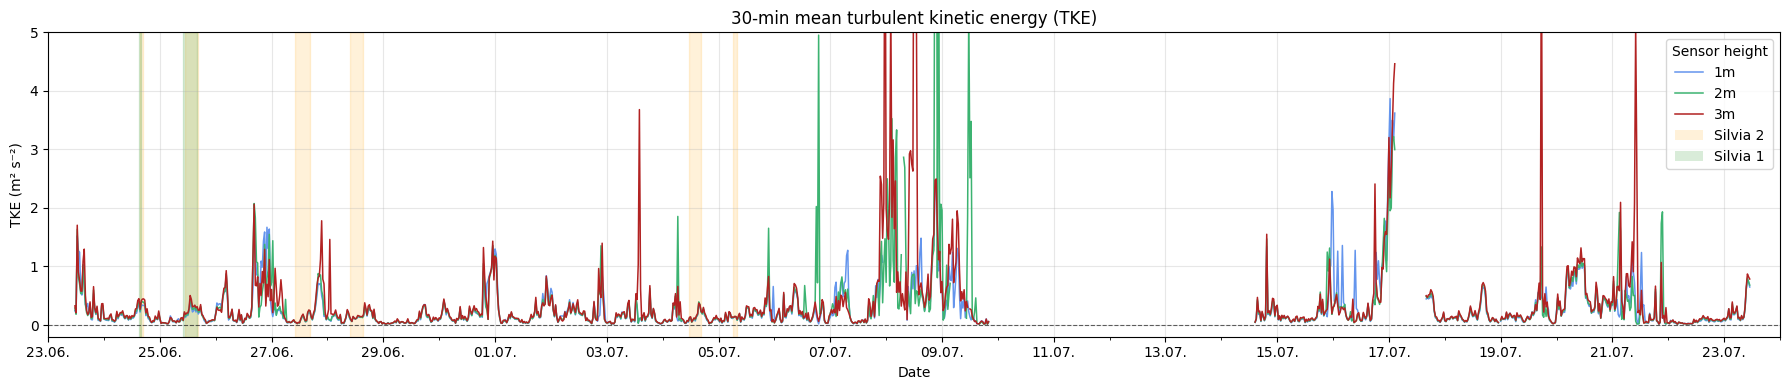

In [16]:
def build_full_output_series(column_keyword: str, transform=None):
    """Collect a per-sensor series for a column stored in the EddyPro full outputs."""
    keyword_groups = [[column_keyword.lower()]]
    series: dict[str, pd.DataFrame] = {}
    for sensor, df in full_outputs.items():
        try:
            timestamp, _ = get_timestamp_series(df)
        except ValueError:
            print(f"Sensor {sensor}: missing timestamp column; skipping {column_keyword}.")
            continue
        col, label = find_column(df, keyword_groups)
        if col is None:
            print(f"Sensor {sensor}: {column_keyword} column not found; skipping.")
            continue
        values = pd.to_numeric(df[col], errors="coerce")
        sensor_df = (
            pd.DataFrame({"timestamp": timestamp, "value": values})
            .dropna(subset=["timestamp"])
            .sort_values("timestamp")
        )
        if transform is not None:
            sensor_df["value"] = transform(sensor_df["value"])
        sensor_df = sensor_df.dropna(subset=["value"])
        if sensor_df.empty:
            print(f"Sensor {sensor}: no valid {column_keyword} values after cleaning; skipping.")
            continue
        series[sensor] = sensor_df
    return series


tke_series = build_full_output_series("tke")
block_avg_freq = "30min"
avg_tke = block_average_series(tke_series, freq=block_avg_freq, preserve_gaps=True)

fig, ax = plt.subplots(figsize=(18, 4))
for sensor in ordered_sensors:
    sensor_data = avg_tke.get(sensor)
    if sensor_data is None or sensor_data.empty:
        continue
    color = COLORS.get(sensor, "gray")
    ax.plot(
        sensor_data["timestamp"],
        sensor_data["value"],
        label=sensor,
        color=color,
        linewidth=1.1,
    )
ax.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.6)
ax.set_title("30-min mean turbulent kinetic energy (TKE)")
ax.set_ylabel("TKE (m² s⁻²)")
ax.set_xlabel("Date")
ax.set_xlim(pd.Timestamp("2025-06-23"), pd.Timestamp("2025-07-24"))
ax.set_ylim(-0.2,5)
ax.grid(True, alpha=0.3)
ax.legend(title="Sensor height")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
ax.tick_params(axis="x", which="major", rotation=0)
fig.autofmt_xdate(rotation=0, ha="center")

# Add measurement window shading
add_measurement_windows(ax)

plt.tight_layout()

In [17]:
def add_measurement_windows(ax, add_legend=True):
    """Add shaded background regions for special measurement periods."""
    from matplotlib.patches import Patch
    
    # Oben (upper location) - light orange - Silvia 2
    oben_windows = [
        ("2025-06-24 15:36", "2025-06-24 16:36"),
        ("2025-06-25 10:35", "2025-06-25 16:35"),
        ("2025-06-27 10:13", "2025-06-27 16:40"),
        ("2025-06-28 09:37", "2025-06-28 15:07"),
        ("2025-07-04 11:24", "2025-07-04 16:24"),
        ("2025-07-05 06:21", "2025-07-05 08:08"),
    ]
    
    # Unten (lower location) - light green - Silvia 1
    unten_windows = [
        ("2025-06-24 15:05", "2025-06-24 16:05"),
        ("2025-06-25 10:07", "2025-06-25 16:07"),
    ]
    
    for start, end in oben_windows:
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                   alpha=0.15, color='orange', zorder=0)
    
    for start, end in unten_windows:
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                   alpha=0.15, color='green', zorder=0)
    
    # Add legend entries if requested
    if add_legend:
        # Get existing handles and labels
        handles, labels = ax.get_legend_handles_labels()
        
        # Create custom patches for the measurement windows
        silvia2_patch = Patch(facecolor='orange', alpha=0.15, label='IR - Silvia 2')
        silvia1_patch = Patch(facecolor='green', alpha=0.15, label='IR - Silvia 1')
        
        # Add to existing handles
        handles.extend([silvia2_patch, silvia1_patch])
        
        # Update legend
        ax.legend(handles=handles, title="Sensor height")

<>:169: SyntaxWarning: invalid escape sequence '\o'
<>:176: SyntaxWarning: invalid escape sequence '\o'
<>:182: SyntaxWarning: invalid escape sequence '\o'
<>:169: SyntaxWarning: invalid escape sequence '\o'
<>:176: SyntaxWarning: invalid escape sequence '\o'
<>:182: SyntaxWarning: invalid escape sequence '\o'
C:\Users\asemannp\AppData\Local\Temp\ipykernel_18776\2849844104.py:169: SyntaxWarning: invalid escape sequence '\o'
  ax_uT.set_title("along-slope sensible heat flux $\overline{u'T'}$ (should have zero crossing for jet)")
C:\Users\asemannp\AppData\Local\Temp\ipykernel_18776\2849844104.py:176: SyntaxWarning: invalid escape sequence '\o'
  ax_uw.set_title("vertical momentum flux $\overline{u'w'}$ (should have zero crossing for jet)")
C:\Users\asemannp\AppData\Local\Temp\ipykernel_18776\2849844104.py:182: SyntaxWarning: invalid escape sequence '\o'
  ax_wT.set_title("vertical sensible heat flux $\overline{w'T'}$")


Data extracted successfully for all sensors


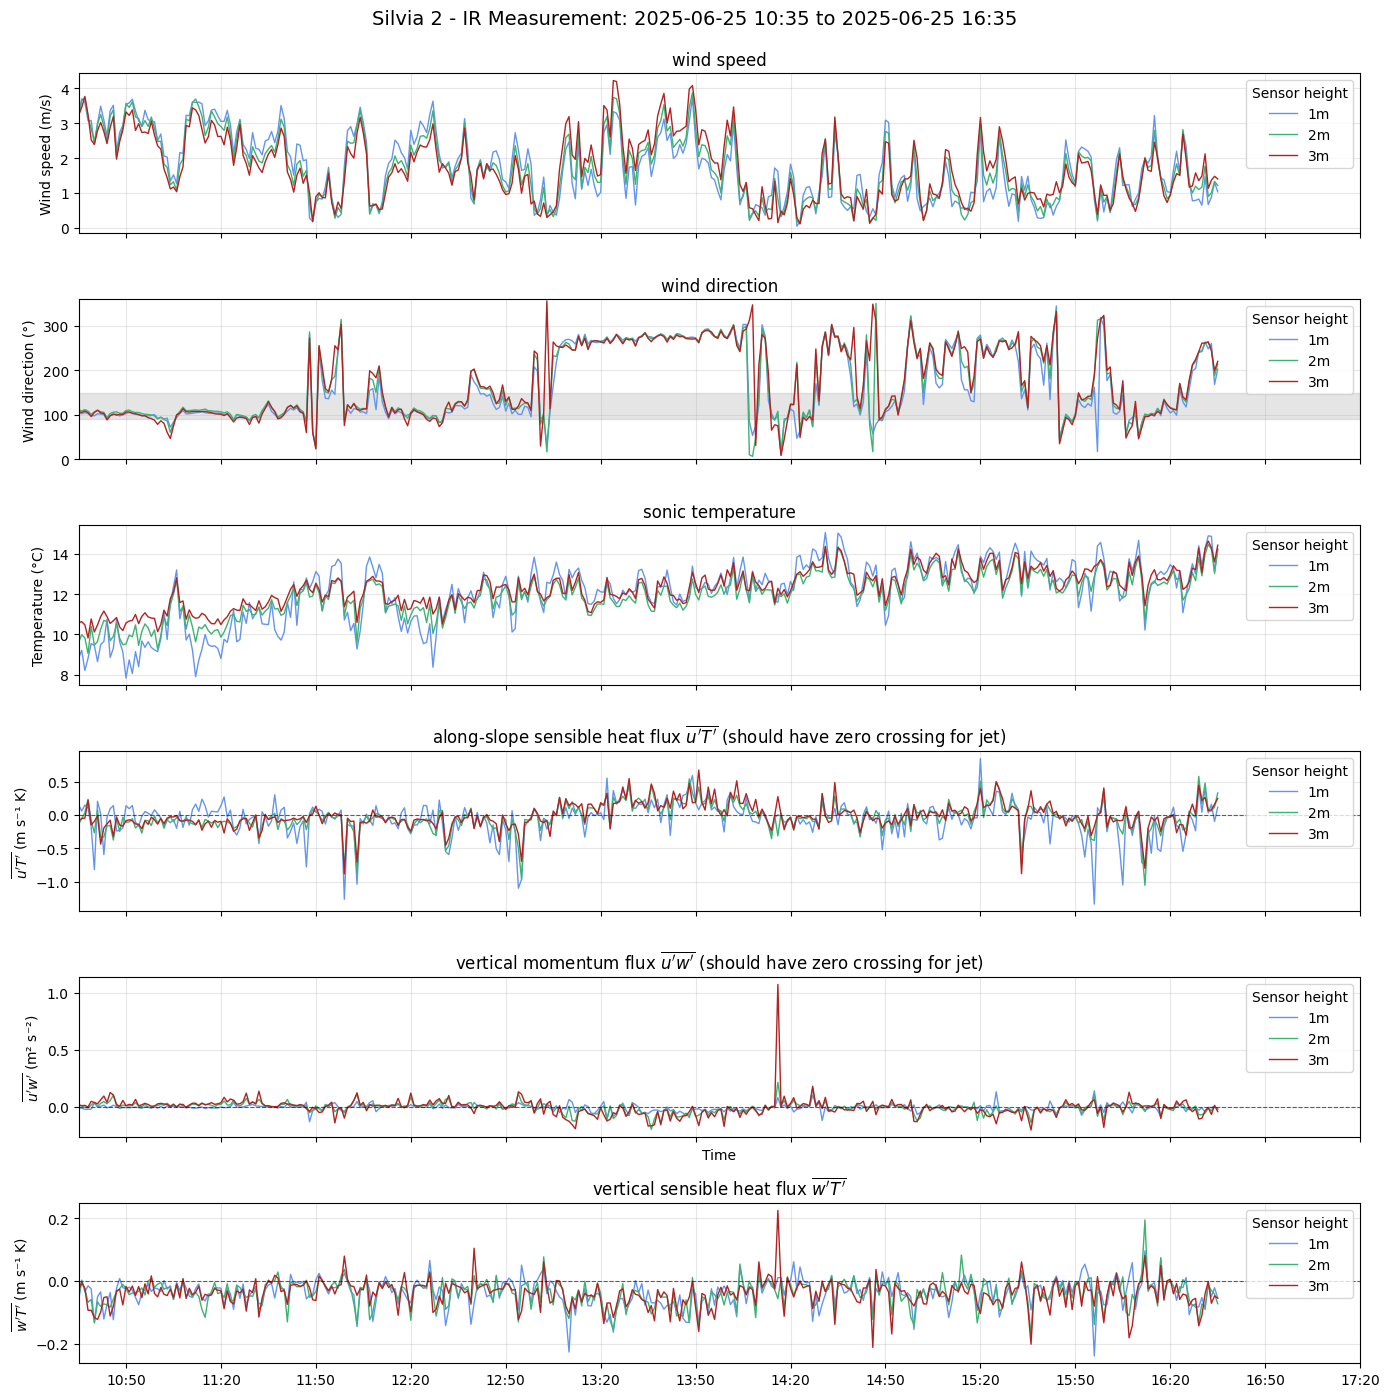

Plotted data for June 25


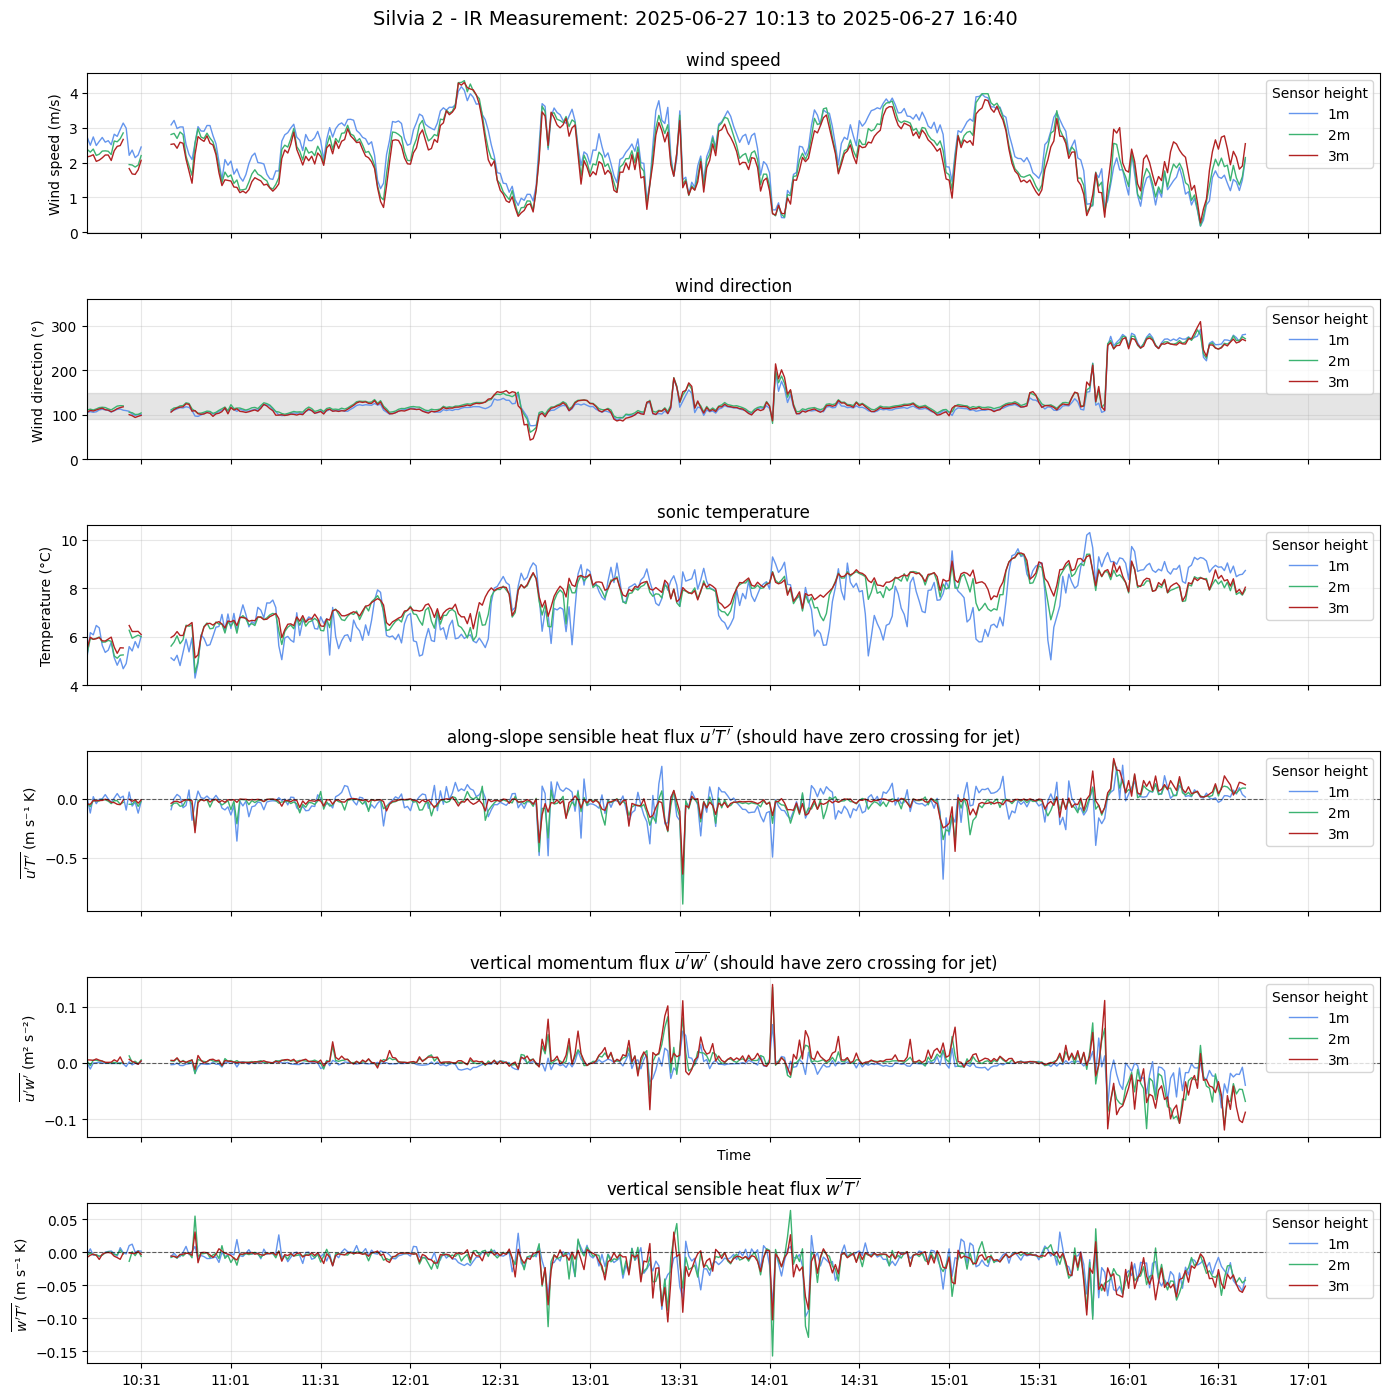

Plotted data for June 27


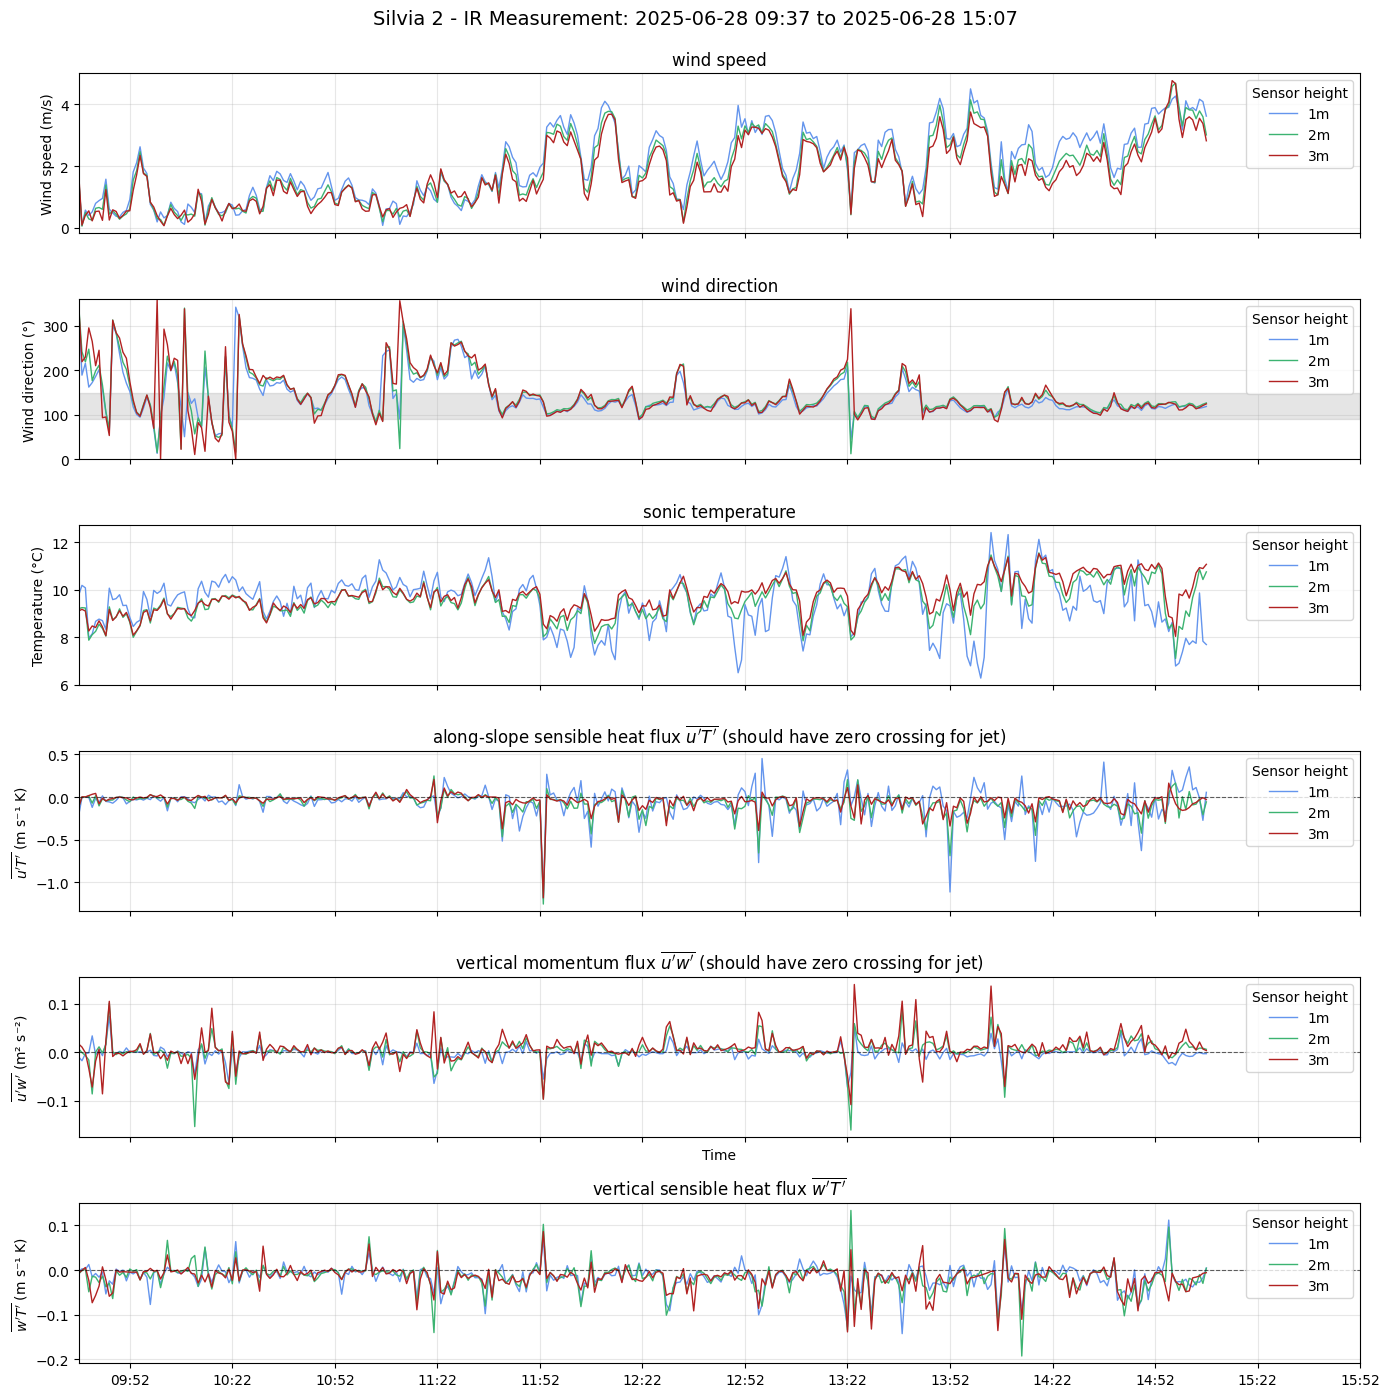

Plotted data for June 28


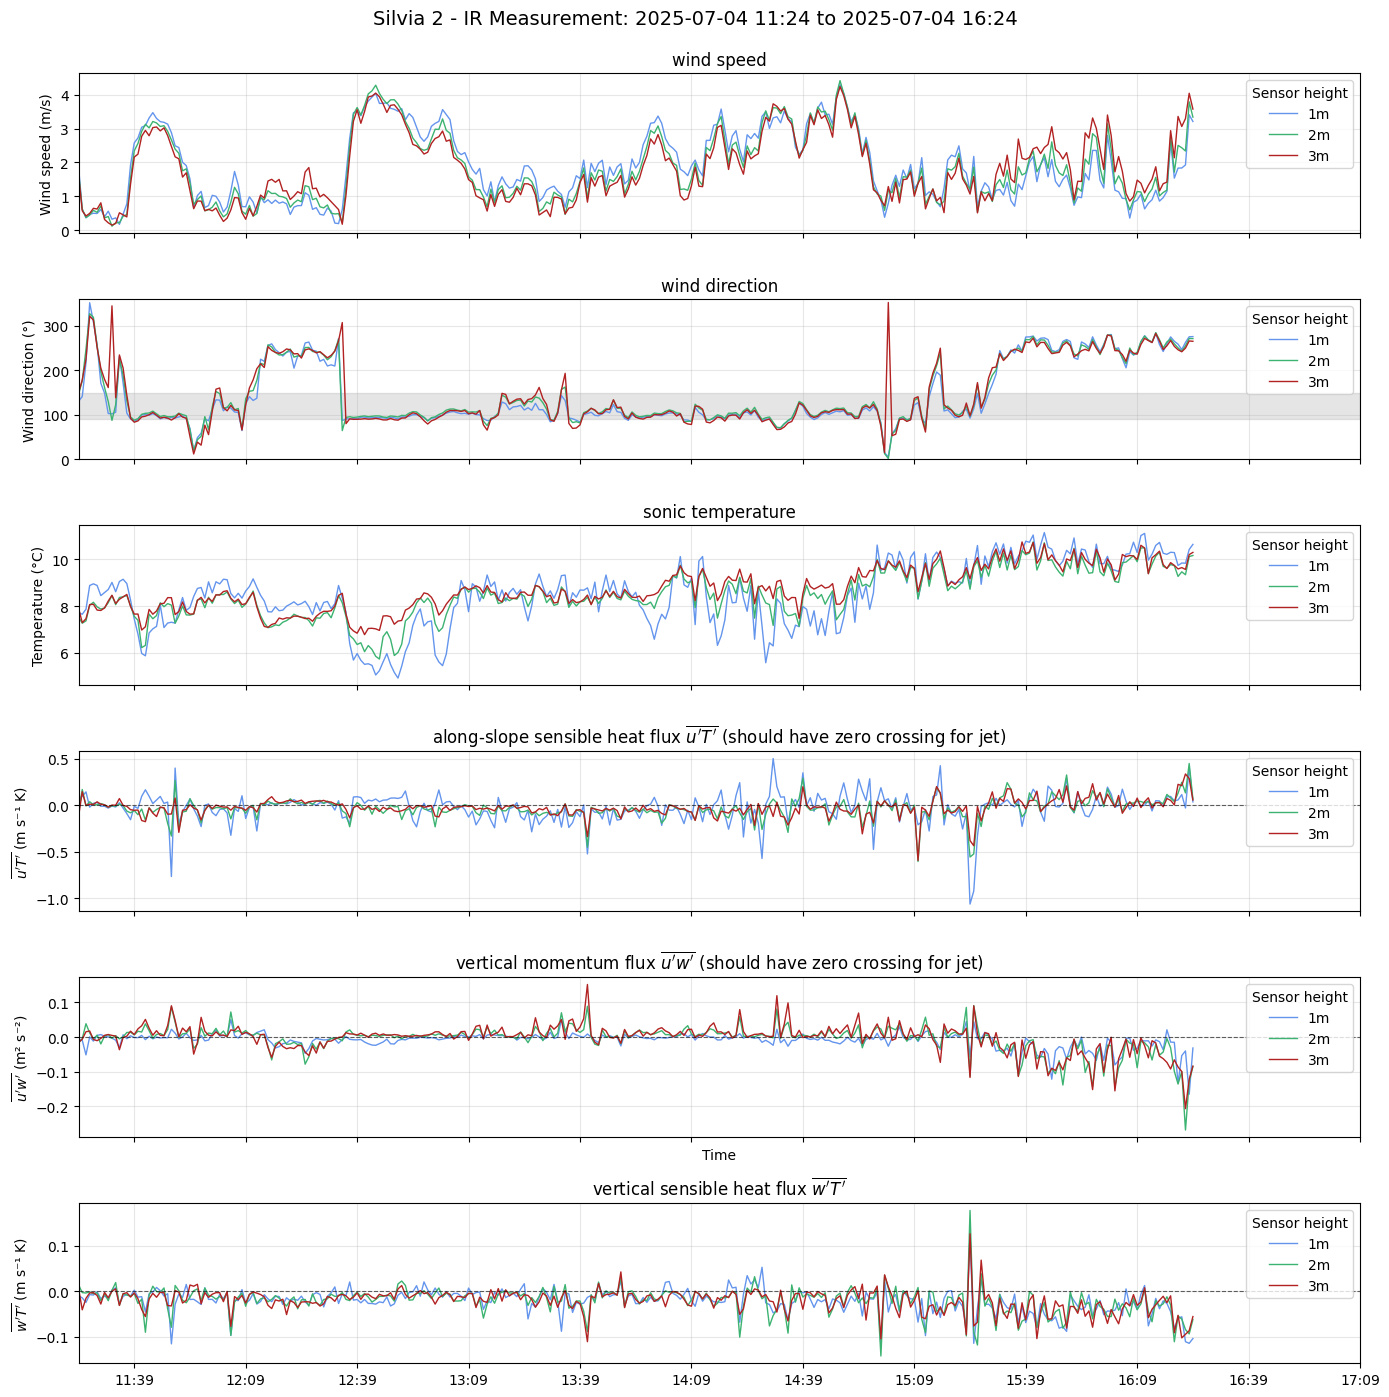

Plotted data for July 4


In [38]:
# Define Silvia 2 (oben) time windows
silvia2_windows = [
    #("2025-06-24 15:36", "2025-06-24 16:36", "June 24"),
    ("2025-06-25 10:35", "2025-06-25 16:35", "June 25"),
    ("2025-06-27 10:13", "2025-06-27 16:40", "June 27"),
    ("2025-06-28 09:37", "2025-06-28 15:07", "June 28"),
    ("2025-07-04 11:24", "2025-07-04 16:24", "July 4"),
    #("2025-07-05 06:21", "2025-07-05 08:08", "July 5"),
]

# Extract data series for all sensors
wind_speed_data = {}
wind_dir_data = {}
sonic_temp_data = {}
flux_uT_data = {}
flux_wT_data = {}
flux_uw_data = {}

for sensor in ordered_sensors:
    df = full_outputs[sensor]
    
    # Get timestamp
    try:
        timestamp, _ = get_timestamp_series(df)
    except ValueError:
        continue
    
    # Wind speed
    ws_col, _ = find_column(df, wind_speed_keywords)
    if ws_col:
        ws_values = pd.to_numeric(df[ws_col], errors="coerce")
        wind_speed_data[sensor] = pd.DataFrame({"timestamp": timestamp, "value": ws_values}).dropna()
    
    # Wind direction
    wd_col, _ = find_column(df, wind_dir_keywords)
    if wd_col:
        wd_values = pd.to_numeric(df[wd_col], errors="coerce")
        wind_dir_data[sensor] = pd.DataFrame({"timestamp": timestamp, "value": wd_values}).dropna()
    
    # Sonic temperature (convert from K to °C)
    temp_col, _ = find_column(df, [["mean(ts)"], ["sonic", "temperature"]])
    if temp_col:
        temp_values = pd.to_numeric(df[temp_col], errors="coerce") - 273.15
        sonic_temp_data[sensor] = pd.DataFrame({"timestamp": timestamp, "value": temp_values}).dropna()

# Extract flux data from ST7 outputs (not full outputs)
for sensor in ordered_sensors:
    df_st7 = st7_outputs[sensor]
    
    # Get timestamp for ST7 data
    try:
        timestamp, _ = get_timestamp_series(df_st7)
    except ValueError:
        continue
    
    # Flux u'T' (along-slope sensible heat flux)
    flux_uT_col, _ = find_column(df_st7, [["cov(u/ts)"]])
    if flux_uT_col:
        flux_uT_values = pd.to_numeric(df_st7[flux_uT_col], errors="coerce")
        flux_uT_data[sensor] = pd.DataFrame({"timestamp": timestamp, "value": flux_uT_values}).dropna()
    
    # Flux u'w' (vertical momentum flux)
    flux_uw_col, _ = find_column(df_st7, [["cov(u/w)"]])
    if flux_uw_col:
        flux_uw_values = pd.to_numeric(df_st7[flux_uw_col], errors="coerce")
        flux_uw_data[sensor] = pd.DataFrame({"timestamp": timestamp, "value": flux_uw_values}).dropna()
    
    # Flux w'T' (vertical sensible heat flux)
    flux_wT_col, _ = find_column(df_st7, [["cov(w/ts)"]])
    if flux_wT_col:
        flux_wT_values = pd.to_numeric(df_st7[flux_wT_col], errors="coerce")
        flux_wT_data[sensor] = pd.DataFrame({"timestamp": timestamp, "value": flux_wT_values}).dropna()

print("Data extracted successfully for all sensors")

# Create plots for each time window
for start_str, end_str, label in silvia2_windows:
    start_time = pd.Timestamp(start_str)
    end_time = pd.Timestamp(end_str)
    
    fig, axes = plt.subplots(6, 1, figsize=(14, 14), sharex=True)
    fig.suptitle(f"Silvia 2 - IR Measurement: {start_str} to {end_str}", fontsize=14, y=0.995)
    plt.xlim(start_time, end_time+pd.Timedelta(minutes=45))
    
    ax_ws, ax_wd, ax_temp, ax_uT, ax_uw, ax_wT = axes
    
    # Plot for each sensor
    for sensor in ordered_sensors:
        color = COLORS.get(sensor, "gray")
        
        # Wind speed
        if sensor in wind_speed_data:
            data = wind_speed_data[sensor]
            mask = (data["timestamp"] >= start_time) & (data["timestamp"] <= end_time)
            filtered = data[mask]
            if not filtered.empty:
                # Resample to 1-min means
                resampled = filtered.set_index("timestamp").resample("1min").mean()
                ax_ws.plot(resampled.index, resampled["value"], label=sensor, color=color, linewidth=1.0)
        
        # Wind direction
        if sensor in wind_dir_data:
            data = wind_dir_data[sensor]
            mask = (data["timestamp"] >= start_time) & (data["timestamp"] <= end_time)
            filtered = data[mask]
            if not filtered.empty:
                # Resample using circular mean for wind direction
                indexed = filtered.set_index("timestamp")
                resampled = indexed["value"].resample("1min").apply(wind_direction_mean)
                ax_wd.plot(resampled.index, resampled.values, label=sensor, color=color, linewidth=1.0)
        
        # Sonic temperature
        if sensor in sonic_temp_data:
            data = sonic_temp_data[sensor]
            mask = (data["timestamp"] >= start_time) & (data["timestamp"] <= end_time)
            filtered = data[mask]
            if not filtered.empty:
                resampled = filtered.set_index("timestamp").resample("1min").mean()
                ax_temp.plot(resampled.index, resampled["value"], label=sensor, color=color, linewidth=1.0)
        
        # Flux u'T'
        if sensor in flux_uT_data:
            data = flux_uT_data[sensor]
            mask = (data["timestamp"] >= start_time) & (data["timestamp"] <= end_time)
            filtered = data[mask]
            if not filtered.empty:
                resampled = filtered.set_index("timestamp").resample("1min").mean()
                ax_uT.plot(resampled.index, resampled["value"], label=sensor, color=color, linewidth=1.0)
        
        # Flux u'w'
        if sensor in flux_uw_data:
            data = flux_uw_data[sensor]
            mask = (data["timestamp"] >= start_time) & (data["timestamp"] <= end_time)
            filtered = data[mask]
            if not filtered.empty:
                resampled = filtered.set_index("timestamp").resample("1min").mean()
                ax_uw.plot(resampled.index, resampled["value"], label=sensor, color=color, linewidth=1.0)

        # Flux w'T'
        if sensor in flux_wT_data:
            data = flux_wT_data[sensor]
            mask = (data["timestamp"] >= start_time) & (data["timestamp"] <= end_time)
            filtered = data[mask]
            if not filtered.empty:
                resampled = filtered.set_index("timestamp").resample("1min").mean()
                ax_wT.plot(resampled.index, resampled["value"], label=sensor, color=color, linewidth=1.0)
        
    
    # Configure axes
    ax_ws.set_ylabel("Wind speed (m/s)")
    ax_ws.set_title("wind speed")
    ax_ws.grid(True, alpha=0.3)
    ax_ws.legend(title="Sensor height", loc="upper right")
    
    ax_wd.set_ylabel("Wind direction (°)")
    ax_wd.set_title("wind direction")
    ax_wd.set_ylim(0, 360)
    # Add shaded region for wind direction 90-150 degrees
    ax_wd.axhspan(90, 150, alpha=0.2, color='gray', zorder=0)
    ax_wd.grid(True, alpha=0.3)
    ax_wd.legend(title="Sensor height", loc="upper right")
    
    ax_temp.set_ylabel("Temperature (°C)")
    ax_temp.set_title("sonic temperature")
    ax_temp.grid(True, alpha=0.3)
    ax_temp.legend(title="Sensor height", loc="upper right")
    
    ax_uT.set_ylabel(r"$\overline{u'T'}$ (m s⁻¹ K)")
    ax_uT.set_title("along-slope sensible heat flux $\overline{u'T'}$ (should have zero crossing for jet)")
    ax_uT.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.6)
    ax_uT.grid(True, alpha=0.3)
    ax_uT.legend(title="Sensor height", loc="upper right")
    
    ax_uw.set_ylabel(r"$\overline{u'w'}$ (m² s⁻²)")
    ax_uw.set_xlabel("Time")
    ax_uw.set_title("vertical momentum flux $\overline{u'w'}$ (should have zero crossing for jet)")
    ax_uw.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.6)
    ax_uw.grid(True, alpha=0.3)
    ax_uw.legend(title="Sensor height", loc="upper right")
    
    ax_wT.set_ylabel(r"$\overline{w'T'}$ (m s⁻¹ K)")
    ax_wT.set_title("vertical sensible heat flux $\overline{w'T'}$")
    ax_wT.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.6)
    ax_wT.grid(True, alpha=0.3)
    ax_wT.legend(title="Sensor height", loc="upper right")
    
    # Format x-axis
    ax_uw.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax_uw.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    ax_uw.tick_params(axis="x", which="major", rotation=45)
    
    plt.tight_layout()
    plt.show()
    print(f"Plotted data for {label}")